In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pylightcurve as plc
import pandas as pd
import random
import os
from pylightcurve.models.exoplanet_lc import PyLCProcessError


# Import additional libraries for ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy import stats
import seaborn as sns

#### Different kinds of variability to add into lightcurve

In [24]:
# Create output directory for plots
os.makedirs('lightcurve_plots', exist_ok=True)

print("Initializing pylightcurve and loading planetary database...")

# Define 7 types of atmospheric/planetary variability
def add_cloud_modulation(time, flux, amplitude=0.001, timescale=0.2):
    """Add cloud modulation with smooth variations - clouds cause dimming"""
    periods = np.array([0.2, 0.5, 1.0, 2.0]) * timescale * (time[-1] - time[0])
    cloud_signal = np.zeros_like(flux)
    for period in periods:
        phase = 2 * np.pi * time / period
        cloud_signal += np.sin(phase + np.random.rand() * 2 * np.pi)

    # Normalize to [-1, 1] then make negative (clouds dim light)
    cloud_signal = cloud_signal / np.max(np.abs(cloud_signal)) * amplitude
    cloud_signal = -np.abs(cloud_signal)  # Ensure always negative (dimming)

    # Apply cloud modulation as multiplicative dimming
    modified_flux = flux * (1 + cloud_signal)

    # Ensure flux never exceeds 1
    return np.minimum(modified_flux, 1.0)

def add_precipitation_variability(time, flux, amplitude=0.0008, n_events=3):
    """Add precipitation events as localized flux variations - precipitation dims light"""
    modified_flux = flux.copy()

    for _ in range(n_events):
        # Random timing and duration for precipitation events
        center_idx = random.randint(len(time)//4, 3*len(time)//4)
        width = random.randint(10, 30)  # Duration in data points

        # Create precipitation signature (dimming events only)
        event_profile = np.zeros_like(flux)
        for i in range(max(0, center_idx-width), min(len(time), center_idx+width)):
            distance = abs(i - center_idx)
            # All precipitation effects cause dimming
            event_profile[i] = -amplitude * np.exp(-distance**2 / (width/3)**2)

        modified_flux += event_profile

    # Ensure flux never exceeds 1
    return np.minimum(modified_flux, 1.0)

def add_atmospheric_haze(time, flux, base_amplitude=0.0005, gradient_strength=0.3):
    """Add atmospheric haze - haze always dims the light"""
    # Create a time-dependent haze that varies smoothly
    haze_period = (time[-1] - time[0]) * 0.8
    phase = 2 * np.pi * (time - time[0]) / haze_period

    # Base haze modulation (always dimming)
    haze_signal = base_amplitude * (1 + gradient_strength * np.abs(np.sin(phase)))
    haze_signal = -haze_signal  # Make negative (dimming)

    # Add some high-frequency structure from particle distribution (also dimming)
    fine_structure = -0.0002 * np.abs(np.sin(10 * phase + np.random.rand() * 2 * np.pi))

    modified_flux = flux * (1 + haze_signal + fine_structure)

    # Ensure flux never exceeds 1
    return np.minimum(modified_flux, 1.0)

def add_magnetic_activity(time, flux, amplitude=0.0012, n_flares=2):
    """Add stellar magnetic activity - starspots dim, but we avoid flares to keep flux <= 1"""
    modified_flux = flux.copy()

    # Only add starspot modulation (dimming) - avoid flares which would brighten
    spot_period = (time[-1] - time[0]) * 1.2
    spot_phase = 2 * np.pi * (time - time[0]) / spot_period

    # Starspot modulation (always dimming)
    spot_modulation = -amplitude * 0.5 * (1 + np.sin(spot_phase + np.random.rand() * 2 * np.pi))
    spot_modulation = np.minimum(spot_modulation, 0)  # Ensure always negative

    # Add magnetic field effects that cause additional dimming
    magnetic_cycles = -amplitude * 0.3 * np.abs(np.sin(3 * spot_phase))

    modified_flux = modified_flux + spot_modulation - magnetic_cycles

    # Ensure flux never exceeds 1
    return np.minimum(modified_flux, 1.0)

def add_thermal_variability(time, flux, amplitude=0.0006, temperature_cycles=2):
    """Add thermal variability - model as absorption changes that dim light"""
    modified_flux = flux.copy()

    # Create thermal cycles as absorption variations (dimming only)
    for i in range(temperature_cycles):
        period = (time[-1] - time[0]) * (0.4 + 0.6 * random.random())
        phase = 2 * np.pi * (time - time[0]) / period + random.random() * 2 * np.pi

        # Thermal absorption varies with temperature (always dimming)
        thermal_signal = -amplitude * (0.5 + 0.5 * i) * np.abs(np.sin(phase))

        # Add some asymmetry due to heat redistribution (also dimming)
        asymmetry = -0.3 * amplitude * np.abs(np.sin(2 * phase + np.pi/4))

        modified_flux += thermal_signal + asymmetry

    # Ensure flux never exceeds 1
    return np.minimum(modified_flux, 1.0)

def add_photochemical_cycles(time, flux, amplitude=0.0008, period_range=(0.1, 0.5)):

    # Generate several overlapping periodic signals
    total_time = time[-1] - time[0]
    n_cycles = np.random.randint(3, 7)
    photo_signal = np.zeros_like(flux)

    for _ in range(n_cycles):
        period = np.random.uniform(period_range[0], period_range[1]) * total_time
        phase = 2 * np.pi * time / period
        phase_shift = np.random.rand() * 2 * np.pi

        # Add asymmetric waveform to simulate chemical buildups and depletions
        cycle = np.sin(phase + phase_shift) + 0.3 * np.sin(2 * phase + phase_shift) - 0.1 * np.sin(3 * phase + phase_shift)

        # Normalize and add to main signal
        cycle = cycle / np.max(np.abs(cycle))
        photo_signal += cycle

    # Normalize and scale
    photo_signal = photo_signal / np.max(np.abs(photo_signal)) * amplitude

    # Apply photochemical variations
    return flux * (1 + photo_signal)

def add_wind_variations(time, flux, amplitude=0.0005, n_features=5):

    # Initialize wind signal
    wind_signal = np.zeros_like(flux)

    # Generate random wind features
    for _ in range(n_features):
        # Random position and width
        pos = np.random.uniform(time[0], time[-1])
        width = np.random.uniform(0.01, 0.1) * (time[-1] - time[0])

        # Add a smooth localized feature
        feature = amplitude * np.exp(-((time - pos) / width) ** 2)

        # Random direction (absorption or emission)
        if np.random.rand() > 0.5:
            feature *= -1

        wind_signal += feature

    # Apply wind variations
    return flux + wind_signal

Initializing pylightcurve and loading planetary database...


#### Adding variability into lightcurves and plotting them

In [25]:
# Define variability types and their functions
variability_types = {
    'Cloud_Modulation': add_cloud_modulation,
    'Precipitation_Events': add_precipitation_variability,
    'Atmospheric_Haze': add_atmospheric_haze,
    'Magnetic_activity': add_magnetic_activity,
    'Photochemical cycles': add_photochemical_cycles,
    'Thermal_Variability': add_thermal_variability,
    'Wind_Variation': add_wind_variations
}

def apply_random_variability(time, flux):
    """Randomly select and apply one type of variability"""
    variability_name = random.choice(list(variability_types.keys()))
    variability_func = variability_types[variability_name]

    if variability_name == 'Cloud_Modulation':
        modified_flux = variability_func(time, flux)
    else:
        modified_flux = variability_func(time, flux)

    return variability_name, modified_flux

def plot_comparison(planet_name, time, original_flux, modified_flux, variability_name):
    """Create comparison plot of original vs modified light curve"""
    plt.figure(figsize=(12, 8))

    # Plot original light curve
    plt.subplot(2, 1, 1)
    plt.plot(time, original_flux, 'b-', linewidth=1.5, label='Original Light Curve')
    plt.ylabel('Relative Flux')
    plt.title(f'{planet_name} - Transit Light Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot modified light curve
    plt.subplot(2, 1, 2)
    plt.plot(time, original_flux, 'b-', alpha=0.5, linewidth=1, label='Original')
    plt.plot(time, modified_flux, 'r-', linewidth=1.5, label=f'With {variability_name.replace("_", " ")}')
    plt.xlabel('Time (BJD_UTC)')
    plt.ylabel('Relative Flux')
    plt.title(f'{planet_name} - Light Curve with {variability_name.replace("_", " ")}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save plot
    safe_planet_name = planet_name.replace(' ', '_').replace('/', '_').replace('\\', '_')
    filename = f"{safe_planet_name}_{variability_name}.png"
    plt.savefig(f'lightcurve_plots/{filename}', dpi=300, bbox_inches='tight')
    plt.close()

    return filename

#### Generating lightcurves using pylightcurve with random variability

In [26]:
# Initialize the main dataframe
planetary_data = pd.DataFrame({
    'PlanetName': [],
    'MidTime': [],
    'Cadence': [],
    'LightCurve': [],
    'VariabilityName': [],
    'VariabilityLightCurve': []
})

# Get all available planets
print("Getting list of all planets...")
all_planets = plc.get_all_planets()
print(f"Found {len(all_planets)} planets in database")

# Process planets (aim for at least 300)
target_planets = min(300, 350)
processed_count = 0
failed_count = 0

print(f"Processing {target_planets} planets...")

# Shuffle the planet list for random sampling
random.shuffle(all_planets)

for i, planet in enumerate(all_planets):
    if processed_count >= target_planets:
        break

    try:
        print(f"Processing planet {processed_count + 1}/{target_planets}: {planet}")

        # Get planet data
        planet_dt = plc.get_planet(planet)
        mid_time = planet_dt.mid_time

        # Create time cadence around transit
        cadence = np.arange(planet_dt.mid_time - 0.15, planet_dt.mid_time + 0.15, 0.001)

        # Generate transit light curve
        lightcurve = planet_dt.transit_integrated(
            cadence,
            time_format='BJD_UTC',
            exp_time=120,
            time_stamp='mid',
            filter_name='COUSINS_R',
            max_sub_exp_time=1
        )

        # Apply random variability
        variability_name, modified_flux = apply_random_variability(cadence, lightcurve)

        # Create comparison plot
        plot_filename = plot_comparison(planet, cadence, lightcurve, modified_flux, variability_name)

        # Add to dataframe
        new_row = pd.DataFrame({
            'PlanetName': [planet],
            'MidTime': [mid_time],
            'Cadence': [cadence],
            'LightCurve': [lightcurve],
            'VariabilityName': [variability_name],
            'VariabilityLightCurve': [modified_flux]
        })
        planetary_data = pd.concat([planetary_data, new_row], ignore_index=True)

        processed_count += 1

        # Print progress every 50 planets
        if processed_count % 50 == 0:
            print(f"Successfully processed {processed_count} planets")

    except PyLCProcessError as e:
        failed_count += 1
        print(f"Skipping {planet} due to PyLC error: {e}")
        continue
    except Exception as e:
        failed_count += 1
        print(f"Skipping {planet} due to unexpected error: {e}")
        continue

print(f"\nProcessing complete!")
print(f"Successfully processed: {processed_count} planets")
print(f"Failed to process: {failed_count} planets")

# Save the dataframe
planetary_data.to_pickle('planetary_data_with_variability.pkl')
print(f"Saved planetary data to 'planetary_data_with_variability.pkl'")

# Display summary statistics
print(f"\nVariability Distribution:")
variability_counts = planetary_data['VariabilityName'].value_counts()
for var_type, count in variability_counts.items():
    print(f"- {var_type.replace('_', ' ')}: {count} planets ({count/len(planetary_data)*100:.1f}%)")

print(f"\nAll plots saved in 'lightcurve_plots/' directory")
print(f"Total plots generated: {len(planetary_data)}")

# Display sample of processed planets
print(f"\nSample of processed planets:")
for idx in range(min(10, len(planetary_data))):
    row = planetary_data.iloc[idx]
    print(f"- {row['PlanetName']}: {row['VariabilityName'].replace('_', ' ')}")

# Basic statistics
if len(planetary_data) > 0:
    print(f"\nBasic Statistics:")
    print(f"- Average transit depth: {np.mean([1 - np.min(lc) for lc in planetary_data['LightCurve']]):.4f}")
    print(f"- Transit duration range: {np.mean([len(cadence) * 0.001 for cadence in planetary_data['Cadence']]):.3f} days")

    # Show variability impact
    impact_samples = []
    for idx in range(min(5, len(planetary_data))):
        original = planetary_data.iloc[idx]['LightCurve']
        modified = planetary_data.iloc[idx]['VariabilityLightCurve']
        rms_change = np.sqrt(np.mean((modified - original)**2))
        impact_samples.append(rms_change)

    print(f"- Average RMS variability impact: {np.mean(impact_samples):.6f}")

print(f"\nDataFrame shape: {planetary_data.shape}")
print("Processing complete! Check the 'lightcurve_plots' folder for individual planet plots.")

Getting list of all planets...
Found 776 planets in database
Processing 300 planets...
Processing planet 1/300: K2-24c
PHOENIX models are only computed for solar metallicity stars. Setting stellar_metallicity = 0.
Fp/Fs estimated using A=0.15, e=1.0 for filter COUSINS_R.
Processing planet 2/300: HATS-45b
PHOENIX models are only computed for solar metallicity stars. Setting stellar_metallicity = 0.
Fp/Fs estimated using A=0.15, e=1.0 for filter COUSINS_R.
Processing planet 3/300: K2-3b
PHOENIX models are only computed for solar metallicity stars. Setting stellar_metallicity = 0.
Fp/Fs estimated using A=0.15, e=1.0 for filter COUSINS_R.
Processing planet 4/300: TOI-262b
PHOENIX models are only computed for solar metallicity stars. Setting stellar_metallicity = 0.
Fp/Fs estimated using A=0.15, e=1.0 for filter COUSINS_R.
Processing planet 5/300: TOI-1431b
PHOENIX models are only computed for solar metallicity stars. Setting stellar_metallicity = 0.
Fp/Fs estimated using A=0.15, e=1.0 for 

#### ML classification using sklearn library

MACHINE LEARNING CLASSIFICATION
Using planetary data already in memory (300 planets)
Extracting features from light curves...
Extracted 10 features from 300 light curves
Training set: 240 samples
Test set: 60 samples

Training ML models...

Training Random Forest...
Random Forest Accuracy: 0.483

Training SVM...
SVM Accuracy: 0.300

Training Logistic Regression...
Logistic Regression Accuracy: 0.250

Best Model: Random Forest (Accuracy: 0.483)

Detailed Classification Report for Random Forest:
                      precision    recall  f1-score   support

    Atmospheric_Haze       0.50      0.62      0.56         8
    Cloud_Modulation       0.56      0.62      0.59         8
   Magnetic_activity       0.50      0.33      0.40         6
Photochemical cycles       0.27      0.33      0.30         9
Precipitation_Events       0.70      0.64      0.67        11
 Thermal_Variability       0.78      0.70      0.74        10
      Wind_Variation       0.00      0.00      0.00         8

   

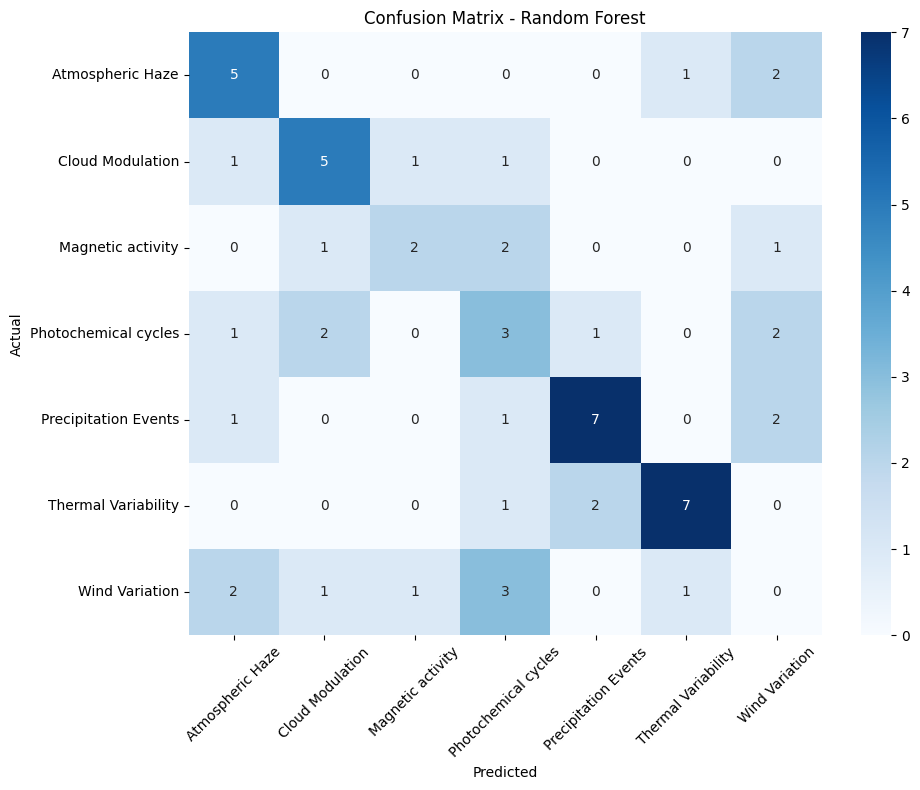

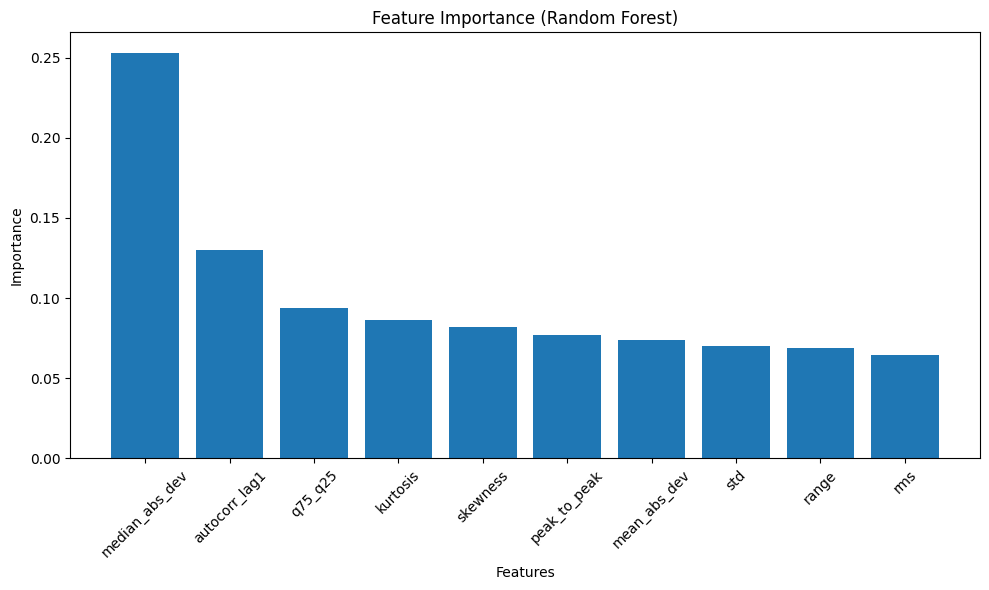


Top 5 Most Important Features:
1. median_abs_dev: 0.253
2. autocorr_lag1: 0.130
3. q75_q25: 0.094
4. kurtosis: 0.086
5. skewness: 0.082


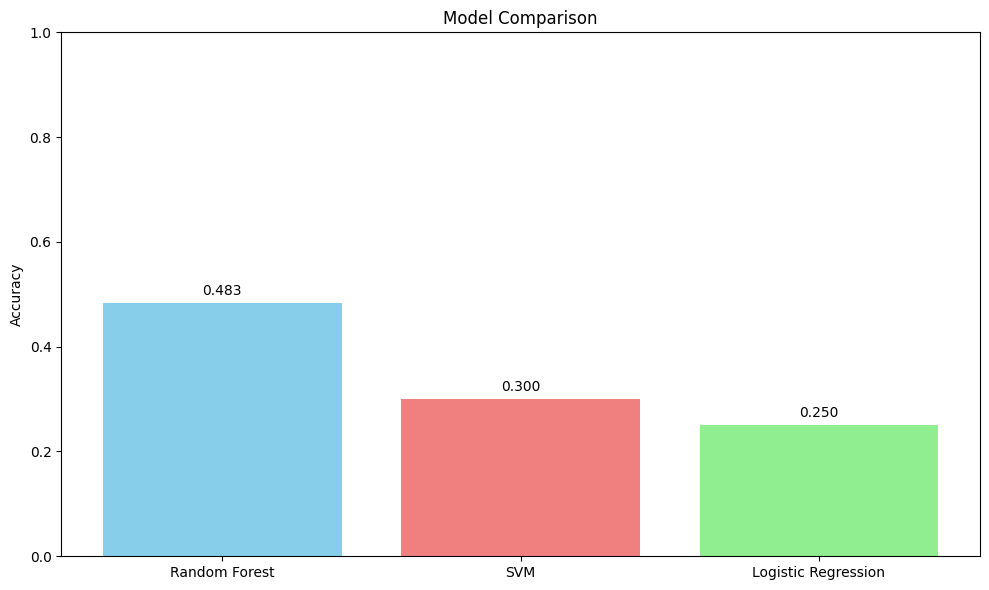


Example Predictions (First 10 test samples):
Actual -> Predicted
✗ Photochemical cycles -> Atmospheric Haze
✗ Atmospheric Haze -> Thermal Variability
✗ Atmospheric Haze -> Wind Variation
✓ Atmospheric Haze -> Atmospheric Haze
✗ Cloud Modulation -> Atmospheric Haze
✓ Atmospheric Haze -> Atmospheric Haze
✓ Precipitation Events -> Precipitation Events
✓ Cloud Modulation -> Cloud Modulation
✗ Wind Variation -> Atmospheric Haze
✓ Atmospheric Haze -> Atmospheric Haze

ML Analysis Complete!
Results saved in 'ml_results/' directory
- Confusion matrix: ml_results/confusion_matrix.png
- Feature importance: ml_results/feature_importance.png
- Model comparison: ml_results/model_comparison.png

Final Summary:
- Processed 300 planets with variability
- Best ML model: Random Forest
- Best accuracy: 0.483
- Feature extraction: 10 statistical features

Test Set Distribution:
- Atmospheric Haze: 8 samples
- Cloud Modulation: 8 samples
- Magnetic activity: 6 samples
- Photochemical cycles: 9 samples
- P

In [27]:
# Create output directory for ML results
os.makedirs('ml_results', exist_ok=True)

print("="*60)
print("MACHINE LEARNING CLASSIFICATION")
print("="*60)

# Load the planetary data if not already in memory
try:
    # Check if planetary_data exists
    if 'planetary_data' not in locals():
        print("Loading planetary data from pickle file...")
        planetary_data = pd.read_pickle('planetary_data_with_variability.pkl')
        print(f"Loaded {len(planetary_data)} planets from file")
    else:
        print(f"Using planetary data already in memory ({len(planetary_data)} planets)")
except FileNotFoundError:
    print("Error: planetary_data_with_variability.pkl not found!")
    print("Please run the light curve generation code first.")
    raise

# Feature extraction functions for ML
def extract_features(time, flux):
    """Extract simple statistical features from light curve"""
    # Remove the transit for variability analysis
    residual = flux - np.mean(flux)

    features = {
        'std': np.std(residual),
        'mean_abs_dev': np.mean(np.abs(residual - np.mean(residual))),
        'skewness': stats.skew(residual),
        'kurtosis': stats.kurtosis(residual),
        'range': np.max(residual) - np.min(residual),
        'q75_q25': np.percentile(residual, 75) - np.percentile(residual, 25),
        'autocorr_lag1': np.corrcoef(residual[:-1], residual[1:])[0,1] if len(residual) > 1 else 0,
        'peak_to_peak': np.max(flux) - np.min(flux),
        'rms': np.sqrt(np.mean(residual**2)),
        'median_abs_dev': np.median(np.abs(residual - np.median(residual)))
    }

    # Handle any NaN values
    for key in features:
        if np.isnan(features[key]) or np.isinf(features[key]):
            features[key] = 0

    return list(features.values())

print("Extracting features from light curves...")

# Extract features for ML
features_list = []
labels_list = []

for idx, row in planetary_data.iterrows():
    time = row['Cadence']
    flux = row['VariabilityLightCurve']
    label = row['VariabilityName']

    # Extract features
    features = extract_features(time, flux)
    features_list.append(features)
    labels_list.append(label)

# Convert to numpy arrays
X = np.array(features_list)
y = np.array(labels_list)

print(f"Extracted {X.shape[1]} features from {X.shape[0]} light curves")

# Feature names for reference
feature_names = ['std', 'mean_abs_dev', 'skewness', 'kurtosis', 'range',
                'q75_q25', 'autocorr_lag1', 'peak_to_peak', 'rms', 'median_abs_dev']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train multiple simple ML models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

print("\nTraining ML models...")

results = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test)
    results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }

    print(f"{model_name} Accuracy: {accuracy:.3f}")

# Find best model
best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_model = results[best_model_name]

print(f"\nBest Model: {best_model_name} (Accuracy: {best_model['accuracy']:.3f})")

# Detailed classification report for best model
print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_test, best_model['predictions']))

# Confusion Matrix
print(f"\nConfusion Matrix for {best_model_name}:")
cm = confusion_matrix(y_test, best_model['predictions'])
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
class_names = [name.replace('_', ' ') for name in np.unique(y)]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('ml_results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance (for Random Forest)
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    feature_importance = rf_model.feature_importances_

    plt.figure(figsize=(10, 6))
    indices = np.argsort(feature_importance)[::-1]
    plt.bar(range(len(feature_importance)), feature_importance[indices])
    plt.xticks(range(len(feature_importance)), [feature_names[i] for i in indices], rotation=45)
    plt.title('Feature Importance (Random Forest)')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.savefig('ml_results/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nTop 5 Most Important Features:")
    for i in range(5):
        idx = indices[i]
        print(f"{i+1}. {feature_names[idx]}: {feature_importance[idx]:.3f}")

# Model comparison plot
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)

# Add accuracy values on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('ml_results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Show some example predictions
print(f"\nExample Predictions (First 10 test samples):")
print("Actual -> Predicted")
for i in range(min(10, len(y_test))):
    actual = y_test[i].replace('_', ' ')
    predicted = best_model['predictions'][i].replace('_', ' ')
    status = "✓" if y_test[i] == best_model['predictions'][i] else "✗"
    print(f"{status} {actual} -> {predicted}")

print(f"\nML Analysis Complete!")
print(f"Results saved in 'ml_results/' directory")
print(f"- Confusion matrix: ml_results/confusion_matrix.png")
print(f"- Feature importance: ml_results/feature_importance.png")
print(f"- Model comparison: ml_results/model_comparison.png")

# Summary statistics
print(f"\nFinal Summary:")
print(f"- Processed {len(planetary_data)} planets with variability")
print(f"- Best ML model: {best_model_name}")
print(f"- Best accuracy: {best_model['accuracy']:.3f}")
print(f"- Feature extraction: {len(feature_names)} statistical features")

# Class distribution in test set
print(f"\nTest Set Distribution:")
unique, counts = np.unique(y_test, return_counts=True)
for class_name, count in zip(unique, counts):
    print(f"- {class_name.replace('_', ' ')}: {count} samples")